# Basic LSP modeling
This is an attempt to replicate Figures 1 and 2 from [1], then adapting it to the 1.06 micron wavelength.

In [9]:
import numpy as np
import scipy.constants as const
import scipy.optimize as sciopt
import matplotlib.pyplot as plt
import constants as c
import saha

CO2_freq = const.c/10.6e-6
Fiber_freq = const.c/1.07e-6

## Figure 1: Degree of Ionization and Electron Density
Using a simplified form of Saha's equation, as given in CHEE 543, calculating degree of ionization, then electron density at... 1 atm??

$$
    \frac{\alpha_\mathrm{i}^2}{1-\alpha_\mathrm{i}^2} \approx 3.2 \times 10^{-2} \frac{T^{5/2}}{p}\exp{\left(-\frac{eE_\mathrm{i}}{k_BT}\right)}
$$

With $\alpha_\mathrm{i}$ related to the particle densities as follows:

$$
    \alpha_\mathrm{i} = \frac{n_\mathrm{i}}{n_\mathrm{i}+n_\mathrm{n}}
$$

### Current issues
- Gabriel seems to pick a specific particle density, where is that from?
- The pressure used in [1] for their Figures is not known

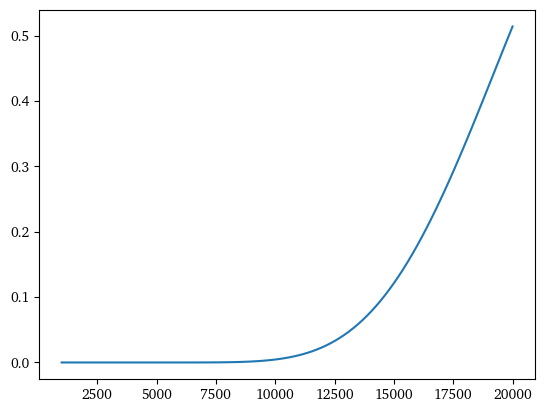

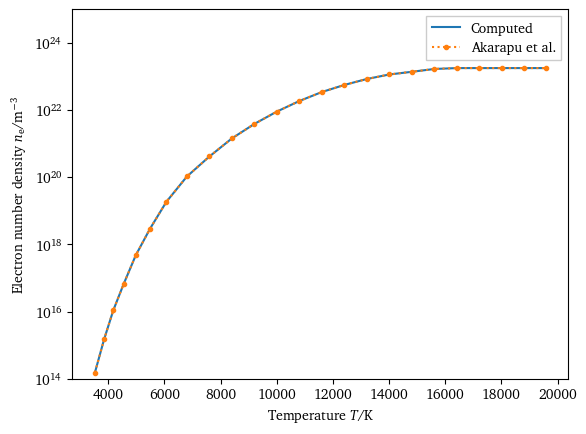

In [10]:
Ei_Argon = 15.759  # eV
R_argon = 208.1  # J kg^-1 K^-1
M_argon = 39.95  # kg kmol^-1
init_temp = 300  # K
temperature = np.linspace(1000, 20000, 100)  # K
pressure = 101300  # Pa

rho = pressure/(R_argon*init_temp)
n_0 = 1000*const.Avogadro*rho/M_argon

# n_0 = 2.6867774e23  # why? idk. n_e is proportional to it so /shrug
n_0 = 2.6867774e24
ionization_mode = 'regular'

ndata = np.loadtxt('../rawdata/akarapu_n.csv', delimiter=',')

if ionization_mode == 'simple':
    alphas = saha.degreeIonization_simple(temperature, pressure, Ei_Argon)
    n_e = alphas*n_0
elif ionization_mode == 'regular':
    n_e = saha.degreeIonization(temperature, Ei_Argon, n_0)
    alphas = n_e/n_0
elif ionization_mode == 'literature':
    popt, pcov = sciopt.curve_fit(
        # lambda x, c1, c2: saha.curvefit(x, c1, c2, n_0),
        lambda x, c1, c2: saha.curvefit(x, c1, c2, n_0),
        ndata[:,0],
        ndata[:,1]
    )
    n_e = saha.curvefit(temperature, popt[0], popt[1], n_0)
    alphas = n_e/n_0

plt.plot(temperature, alphas)
plt.show()

temperature = ndata[:,0]
n_e = ndata[:,1]

plt.semilogy(temperature, n_e, label='Computed')
plt.semilogy(ndata[:,0], ndata[:,1], ':.', label='Akarapu et al.')
plt.xlabel(r'Temperature $T$/K')
plt.ylabel(r'Electron number density $n_\mathrm{e}$/m$^{-3}$')
plt.ylim(1e14, 1e25)
plt.legend()
plt.show()

## Figure 2: Inverse-Brehmsstrahlung Absorption
We then compute the absorption coefficient by inverse-brehmsstrahlung using the following equation:
$$
    \alpha = \frac{7.8\times 10^{-7}Zn_\mathrm{e}^2\ln{\Lambda}}{\nu^2T_\mathrm{e}^{3/2}} \left(1-\frac{\nu_\mathrm{p}^2}{\nu^2}\right)^{-1/2}
$$
Where (from [1], original equation given in [4]):
- $\alpha$ is the absorption coefficient [1/m]
- $Z$ is the ionic charge, and is set to 1 for single ionization
- $n_\mathrm{e}$ is calculated from the previous step [cm^-3]
- $\ln{\Lambda} \approx 23-\ln{(n_\mathrm{e}^{1/2}ZT_\mathrm{e}^{-3/2})}$ [2] page 34
- $T_\mathrm{e}$ is the electron temperature [eV]
- $\nu$ is the laser frequency
- $\nu_\mathrm{p} \sim 8980\sqrt{n_\mathrm{e}}$ is the plasma frequency, for electron density expressed in cm^-3 [3]

### Aside: Where does 8980 come from?
The equation for plasma frequency (angular) is as follows, yielding a value in rad/s when using a consistent system of units:
$$
    \omega_\mathrm{pe}^2 = \frac{n_\mathrm{e}e^2}{\epsilon_0 m_\mathrm{e}}
$$
A frequency in Hz is often used and more practical. We can get it by dividing the angular frequency by $2\pi$:
$$
    f_\mathrm{pe} = \frac{\omega_\mathrm{pe}}{2\pi} = \frac{1}{2\pi}\sqrt{\frac{n_\mathrm{e}e^2}{\epsilon_0 m_\mathrm{e}}}
$$
Since most parameters are constants, we can group them up:
$$
    f_\mathrm{pe} = \frac{1}{2\pi}\sqrt{\frac{e^2}{\epsilon_0 m_\mathrm{e}}}\sqrt{n_\mathrm{e}}
$$
Turns out they evaluate to the following in SI units:
$$
    \frac{1}{2\pi}\sqrt{\frac{e^2}{\epsilon_0 m_\mathrm{e}}} = \biggl\{
        \begin{array}{l}
            8.97885\;\text{m}^{3/2}\text{s}^{-1} \\
            8978.85\;\text{cm}^{3/2}\text{s}^{-1} 
        \end{array}
$$

### Problem
$\ln{\Lambda} \approx 23-\ln{(n_\mathrm{e}^{1/2}ZT_\mathrm{e}^{-3/2})}$ is not really valid... Johnston and Dawson [1] state the following:

> at frequencies well above the plasma frequency $\nu_\mathrm{p}$, $\ln{\Lambda}(\nu)$ should contain the wave frequency $\nu$ rather than the plasma frequency $\nu_\mathrm{p}$.

When we plot our frequencies:

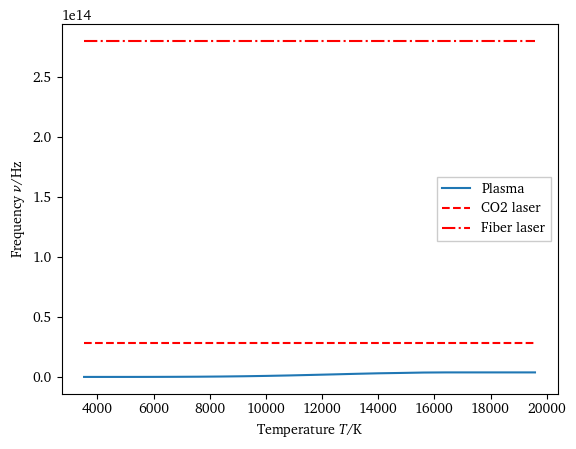

In [11]:
laser_freq = CO2_freq
# laser_freq = Fiber_freq

n_e_cm = n_e*100**-3  # Conversion from m^-3 to cm^-3
Z = 1  # not 100% sure about this
T_e = temperature/11604  # eV

plasma_freq = lambda ne_cm: 8978.85*np.sqrt(ne_cm)
plt.plot(temperature, plasma_freq(n_e_cm), label="Plasma")
plt.plot(temperature, CO2_freq*np.ones(temperature.shape), '--r', label="CO2 laser")
plt.plot(temperature, Fiber_freq*np.ones(temperature.shape), '-.r', 
         label="Fiber laser")
plt.xlabel(r'Temperature $T$/K')
plt.ylabel(r'Frequency $\nu$/Hz')
plt.legend()
plt.show()

We're well beyond the plasma frequency at fiber laser frequencies!

Furthermore:

$$\Lambda(\nu) = \min{\left(\frac{v_T}{\omega_\mathrm{p}\rho_\mathrm{min}}, \frac{v_T}{\omega\rho_\mathrm{min}}\right)}$$

Where $v_T$ is the thermal velocity of the electrons, and $\rho_\mathrm{min}$ is the minimum impact parameters of electron-ion collisions, which can be approximated as

$$\rho_\mathrm{min} \approx \max{\left(\frac{Ze^2}{k_BT}, \frac{\hbar}{(m_\mathrm{e}k_BT)^{1/2}}\right)}$$

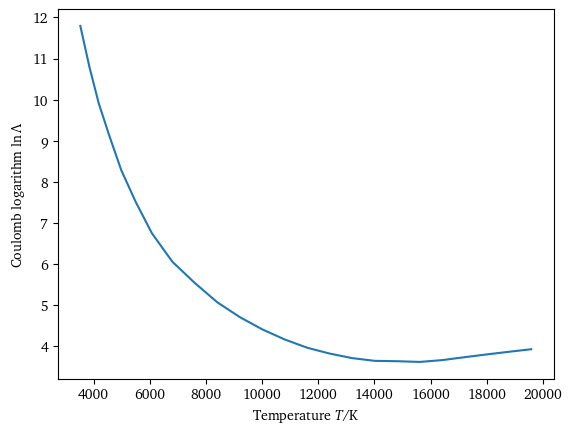

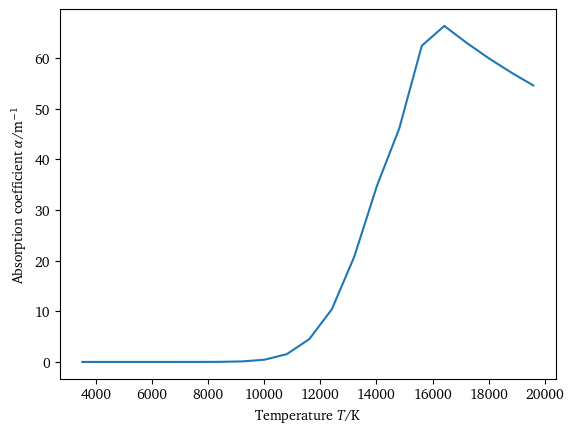

In [12]:
coulombLog = lambda ne, Te: 23 - np.log(ne**0.5*Z*Te**-1.5)
absorption = 7.8e-7*Z*n_e_cm**2*coulombLog(n_e_cm, T_e) \
    / (laser_freq**2*T_e**1.5) \
    * (1-(plasma_freq(n_e_cm)/laser_freq)**2)**-0.5

plt.plot(temperature, coulombLog(n_e_cm, T_e))
plt.xlabel(r'Temperature $T$/K')
plt.ylabel(r'Coulomb logarithm $\ln{\Lambda}$')
plt.show()

plt.plot(temperature, absorption)
plt.xlabel(r'Temperature $T$/K')
plt.ylabel(r'Absorption coefficient $\alpha$/m$^{-1}$')
plt.show()

## References
[1]: Akarapu, R., Abdalla Ramadan Nassar, S. M. Copley, and J. A. Todd. ["Numerical model of a laser-sustained argon plasma."](https://doi.org/10.2351/1.3263120) *Journal of Laser Applications* 21, no. 4 (2009): 169-175.  
[2]: NRL Plasma Formulary  
[3]: Gurnett, Donald A., and Amitava Bhattacharjee. *Introduction to plasma physics: With space, laboratory and astrophysical applications*. Cambridge University Press, 2017.  
[4]: Johnston, Tudor Wyatt, and John M. Dawson. ["Correct values for high‐frequency power absorption by inverse bremsstrahlung in plasmas."](https://doi.org/10.1063/1.1694419) *The Physics of Fluids* 16, no. 5 (1973): 722-722.